In [ ]:
from rdkit import Chem,RDLogger
from rdkit.Chem import Descriptors,rdFMCS,Draw,rdChemReactions,MolStandardize
import pandas as pd
import numpy as np
import ast,copy,collections,re,os
from itertools import combinations,combinations_with_replacement
import itertools


In [ ]:
### Where reaxys file is stored
# ==================
reaxys_csv = 'datafiles/ReaxysBase_ene.csv'
# ==================

for d in ['datafiles','tempfiles','outputfiles']:
    if not os.path.isdir(d):
        os.mkdir(d)

In [ ]:
def clean_rxn(rxnsmiles:str,stereo:bool=True):
    """Sanitize a reaction SMILES"""
    reactants,products = rxnsmiles.split('>>')
    return f"""{clean_smiles(reactants,stereo=stereo)}>>{clean_smiles(products,stereo=stereo)}"""

def clean_smiles(smiles:str,stereo:bool=True):
    """Santitize a SMILES"""
    return Chem.MolToSmiles(Chem.MolFromSmiles(smiles),isomericSmiles=stereo)

def remove_stereo(possible_rxns:str):
    """If multiple products, return a unique list of reaction SMILES with chirality tags removed"""
    if len(possible_rxns) <= 1:
        return possible_rxns
    possible_rxns_noStereo = []
    for rxn in possible_rxns:
        reactants,products = rxn.split('>>')
        possible_rxns_noStereo.append(f'{Chem.MolToSmiles(Chem.MolFromSmiles(reactants),isomericSmiles=False)}>>{Chem.MolToSmiles(Chem.MolFromSmiles(products),isomericSmiles=False)}')
    return list(set(possible_rxns_noStereo))

def getrxn(rxn:str,yields:list,bondchange:bool=True,nostereo:bool=False):
    """Extract reactions via atom economy and bond changes. Chirality is removed in cases of conflicting
    stereochemistry information.
    Returns a list of reaction SMILES"""
    
    rsmiles,psmiles = rxn.split('>>')
    if len(rsmiles)==0 or len(psmiles) ==0:
        return False
    products = psmiles.split('.')
    
    ### 1) Get major product or list of products to test later
    if pd.isna(yields):
        yi = None
    else:
        yi = [float(x) for x in yields.split(';')]
    
    ### if 1 product, major product is this product
    if len(products) == 1: 
        majorprod = products
    elif yi != None and len(yi) == len(products): 
        ### If the number of yields is equal to the number of products
        max_index = yi.index(max(yi))
        majorprod = [products[max_index]]
    else: ### Have to determine later
        majorprod = products
    
    ### 2) Determine reactants
    #### Use atom economy to check in cases of >1 reactants
    reactants = rsmiles.split('.')
    pmasses = {}
    for x in majorprod:
        try: pmasses[x] = Descriptors.HeavyAtomMolWt(Chem.MolFromSmiles(x))
        except: pass ### If a mol cannot be created, SMILES is invalid
    rmasses = {}
    for x in reactants:
        try: rmasses[x] = Descriptors.HeavyAtomMolWt(Chem.MolFromSmiles(x))
        except: pass ### If a mol cannot be created, SMILES is invalid
    rcombos = [list(x) for x in combinations_with_replacement(rmasses.keys(),2)] + [[x] for x in list(rmasses.keys())]
    rcombos = {'.'.join(x):sum([rmasses[y] for y in x]) for x in rcombos}
    pcombos = [[x] for x in list(pmasses.keys())]
    pcombos = {'.'.join(x):sum([pmasses[y] for y in x]) for x in pcombos}
    viable_rxns = []
    for k,v in rcombos.items():
        for k2,v2 in pcombos.items():
            if abs(v-v2)<=0.01:
                viable_rxns.append(f'{k}>>{k2}')
    viable_rxns = [x for x in viable_rxns if len(set(x.split('>>')))!=1]
    
    ### Optional cleaning steps
    if bondchange:
        viable_rxns = enebondchange(viable_rxns)
    
    if nostereo and len(viable_rxns)>1:
        viable_rxns = remove_stereo(viable_rxns)
    return viable_rxns

def enebondchange(rxns:list):
    """Check that the bond change between reactants and products matches the epxectations for Ene reactions.
    Returns a list of reaction SMILES"""
    validrxns = []
    for rxn in rxns:
        rsmiles,psmiles = rxn.split('>>')
        ### The aromaticity needs to be removed. (Ex: If a furan is created, extra aromatic bonds are created)
        rmol = Chem.MolFromSmiles(rsmiles)
        pmol = Chem.MolFromSmiles(psmiles)
        Chem.Kekulize(rmol, clearAromaticFlags=True)
        Chem.Kekulize(pmol, clearAromaticFlags=True)
        
        rbonds = collections.Counter([str(x.GetBondType()) for x in rmol.GetBonds()])
        pbonds = collections.Counter([str(x.GetBondType()) for x in pmol.GetBonds()])
        if 'TRIPLE' in rbonds.keys():
            if (pbonds['TRIPLE']-rbonds['TRIPLE'])==-1 and ((pbonds['DOUBLE']+pbonds['AROMATIC'])-(rbonds['DOUBLE']+rbonds['AROMATIC']))==1 and (pbonds['SINGLE'] - rbonds['SINGLE'])==1:
                validrxns.append(rxn)
            elif (pbonds['TRIPLE']-rbonds['TRIPLE'])==0 and ((pbonds['DOUBLE']+pbonds['AROMATIC'])-(rbonds['DOUBLE']+rbonds['AROMATIC']))==-1 and (pbonds['SINGLE'] - rbonds['SINGLE'])==2:
                validrxns.append(rxn)
        else:
            if ((pbonds['DOUBLE']+pbonds['AROMATIC'])-(rbonds['DOUBLE']+rbonds['AROMATIC']))==-1 and (pbonds['SINGLE'] - rbonds['SINGLE'])==2:
                validrxns.append(rxn)
    return validrxns

def getsharedrxn(rxnlist:list):
    """Given a list of reactions, check if they contain the same reaction but with different reported
    stereochemistry.
    Return a list"""
    rxns = [x[0] for x in rxnlist if len(x) ==1]
    if len(rxns) == 0:
        return False
    if len(set(rxns)) ==1:
        return clean_rxn(rxns[0])
    elif len(set([clean_rxn(x,stereo=False) for x in rxns])) ==1:
        for x in rxns:
            if '@' in x:
                return clean_rxn(x)
    else:
        return False

def rxnwithHs(rxn:str):
    """Add explicit hydrogens to a reaction SMILES.
    Return SMILES"""
    rsmiles,psmiles = rxn.split('>>')
    rmol = Chem.MolFromSmiles(rsmiles)
    pmol = Chem.MolFromSmiles(psmiles)
    rmol = Chem.AddHs(rmol)
    pmol = Chem.AddHs(pmol)
    return f'{Chem.MolToSmiles(rmol)}>>{Chem.MolToSmiles(pmol)}'


Considerations:
1) General Reaction Mechanism
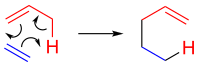
2) Tautomerizations Can Occur Afterwards

# 0) Reaxys to DF

In [ ]:
df_ref = pd.read_csv(reaxys_csv)
print(df_ref.shape)
df_ref = df_ref.dropna(subset=['Reaction'],axis=0)
df_ref['rxn_list'] = df_ref.apply (lambda row: getrxn(row['Reaction'],row['Yield (numerical)'],True,True), axis=1)
df_ref['rxn_listLEN'] = df_ref.apply (lambda row: len(row['rxn_list']), axis=1)
df_ref = df_ref[df_ref['rxn_listLEN']>0]
df_ref = df_ref.groupby('Reaction ID').agg({col: list for col in df_ref.columns if col != 'Reaction ID'}).reset_index()
df_ref['CleanedReactionSmiles'] = df_ref.apply (lambda row: getsharedrxn(row['rxn_list']), axis=1)
df_ref = df_ref[df_ref['CleanedReactionSmiles']!=False]
df_ref['CleanedReactionSmilesHs'] = df_ref.apply (lambda row: rxnwithHs(row['CleanedReactionSmiles']), axis=1)
print(df_ref.shape)
df_ref.to_csv(f'tempfiles/Ene_MasterDetails_{df_ref.shape[0]}.csv')
df_ref.to_pickle(f'tempfiles/Ene_MasterDetails_{df_ref.shape[0]}.pkl')
df_ref


# 1) Correct for Tautomerization and Validate Reaction

In [ ]:
def auto_gen_templates(base_template:str,atomtypes:dict,wildcard:str='Xx'):
    """ Produce list of all possible template enumerations for reactions with heteroatoms.
    A base template SMARTS string is submitted with wildcard slots replaced with Xx. 2 dictionaries
    are then provided for each component of the template with a number (string type) as the key and
    atom type ('C' for example).
    Return a list of templates."""
    rsmiles,psmiles = base_template.split('>>')
    atoms = re.findall(fr'{wildcard}\:\d+',rsmiles)
    starting_index = min([int(x.split(':')[1]) for x in atoms])
    all_combos = [x for x in itertools.product(atomtypes,repeat=len(atoms))]
    all_templates = []
    for c in all_combos:
        template_draft = copy.copy(base_template)
        for n,i in enumerate(c):
            template_draft = template_draft.replace(f'{wildcard}:{n+starting_index}',f'{atomtypes[i]}:{n+starting_index}')
        all_templates.append(template_draft)
    return all_templates

def gen_rdkit_outcomes(smiles:str,all_templates:dict):
    """Using templates, detect which are applicable to the given SMILES and then
    generate a list of possible products using all relevant reaction templates.
    Return a unique list of possible products"""
    reactants = smiles
    ### If we take into account all possible templates, we can have hundereds of thousands or millions
    ### If we use the template dictionary where the atoms involved in the template (ex: cno) are the key
    ### we can quickly find which reactions have the template atoms. With that knowledge, we can then check
    ### for bonding patterns and only use those templates to further reduce the cost of running rdchiral
    react_key = set(copy.copy(reactants).replace('Si','')) 
    useable_temps = []
    for k,v in all_templates.items():
        if len(set(k)-set(react_key)) ==0:
            useable_temps.append(v)
    useable_temps = [x for y in useable_temps for x in y]
    
    reactant_mol=Chem.MolFromSmiles(reactants)

    ### only use templates if the reactants have the template substructure
    useable_temps = [x for x in useable_temps if reactant_mol.HasSubstructMatch(Chem.MolFromSmarts(x.split('>>')[0][1:-1]))]    
    
    products_ls = []
    for template in useable_temps: #    for template in all_templates:
        rxn = rdChemReactions.ReactionFromSmarts(template)
        products_ls += [Chem.MolToSmiles(x[0]) for x in rxn.RunReactants((reactant_mol,))]
    return list(set(products_ls))

def gentauts(prd:str):
    """Given a product SMILES, generate all possible tautomerizations and validate their SMILES
    Return a list of valid tautomerizations"""
    pmol = Chem.MolFromSmiles(prd)
    if pmol==None:
        return []
    validtauts = []
    try:
        for x in tautgen.Enumerate(pmol): 
            ### Some SMILES will be invalid because of valency but I try to see if it is a stereo issue
            psmiles = Chem.MolToSmiles(x)
            ### SMILES without chiral information can also be supplied.
            psmilesnostereo = Chem.MolToSmiles(x,isomericSmiles=False)
            if Chem.MolFromSmiles(psmiles)!=None:
                validtauts.append(psmiles)
            elif Chem.MolFromSmiles(psmilesnostereo)!=None:
                validtauts.append(psmilesnostereo)
            else:
                pass
    except:
        return []
    return validtauts

def getrealprod(rxn:str,templates:dict):
    """Given a reaction and possible templates, identify the possible products and cross verify these
    against tautomerizations of the reported product. If the reported product is a tautomerization of 
    an Ene reaction, return the SMILES of the reaction prior to tautomerization. If the reported product
    is correct, return a SMILES with the reported product.
    Returns a SMILES string or False"""
    rsmiles,psmiles = rxn.split('>>')
    possibleprods = gen_rdkit_outcomes(rsmiles,templates)
    possibleprodsnostereo = [clean_smiles(x,stereo=False) for x in possibleprods if Chem.MolFromSmiles(x) is not None]
    psmilesnostereo = clean_smiles(psmiles,stereo=False)
    if psmiles in possibleprods:
        return f'{rsmiles}>>{psmiles}'
    elif psmilesnostereo in possibleprodsnostereo:
        return f'{clean_smiles(rsmiles,stereo=False)}>>{psmilesnostereo}'
    else:
        for x in possibleprods:
            tautomers = gentauts(x)
            if psmiles in tautomers:
                return f'{rsmiles}>>{psmiles}'
            elif psmilesnostereo in [clean_smiles(x,stereo=False) for x in tautomers]:
                return f'{clean_smiles(rsmiles,stereo=False)}>>{psmilesnostereo}'
            else: pass
    return False


## 1.1) Generate Templates

In [ ]:
enetemp1 = '([Xx:1]-[Xx:2]:,=[Xx:3].[Xx:4]:,=[Xx:5])>>[Xx:5]-[Xx:4]-[Xx:3]-[Xx:2]=[Xx:1]'
enetemp2 = '([Xx:1]-[Xx:2]:,=[Xx:3].[Xx:4]#[Xx:5])>>[Xx:5]=[Xx:4]-[Xx:3]-[Xx:2]=[Xx:1]'
enetemp3 = '([Xx:1]-[Xx:2]#[Xx:3].[Xx:4]:,=[Xx:5])>>[Xx:5]-[Xx:4]-[Xx:3]=[Xx:2]=[Xx:1]'
enetemp4 = '([Xx:1]-[Xx:2]#[Xx:3].[Xx:4]#[Xx:5])>>[Xx:5]=[Xx:4]-[Xx:3]=[Xx:2]=[Xx:1]'
## Including explicit hydrogens in the templates does not work

all_templates_ene = [enetemp1,enetemp2,enetemp3,enetemp4]

fin_templates = []
for x in all_templates_ene:
    fin_templates+=(auto_gen_templates(x,{'0':'C','1':'N','2':'O','3':'c','4':'n','5':'o','6':'S','7':'s'}))
print(f'{len(fin_templates)} templates')

### Make a dictionary where the key is the template and the values are the unique elements in template
fin_temp_keys = [''.join(sorted([y for y in set(x) if y.isalpha()])) for x in fin_templates]
fin_temp_sort = {x:fin_temp_keys[n] for n,x in enumerate(fin_templates)}

### Group these templates based on what elements are contained in them (group based on their key from before)
fin_temp_dic = {}
print(len(set(fin_temp_keys)))
for n,k in enumerate(set(fin_temp_keys)):
    print(n,'\r',end='')
    fin_temp_dic[k] = [x for x,v in fin_temp_sort.items() if k == v]
    
print(f'{len(fin_temp_dic)} groups of templates.')

## 1.2) Generate Possible Products and Check Tautomers

In [ ]:
RDLogger.DisableLog('rdApp.*') 
df_taut = pd.read_pickle(f'tempfiles/Ene_MasterDetails_2782.pkl')
df_taut['CleanedReactionSmilesTaut'] = df_taut.apply (lambda row: getrealprod(row['CleanedReactionSmiles'],fin_temp_dic), axis=1)
df_taut.to_csv(f'tempfiles/Ene_MasterDetails_Taut{df_taut.shape[0]}.csv')
df_taut.to_pickle(f'tempfiles/Ene_MasterDetails_Taut{df_taut.shape[0]}.pkl')
df_tautvalid = df_taut[df_taut['CleanedReactionSmilesTaut']!=False]

for x in ['CleanedReactionSmiles','CleanedReactionSmilesHs','CleanedReactionSmilesTaut']:
    df_tautvalid = df_tautvalid.drop_duplicates(subset=[x])

df_tautvalid.to_csv(f'outputfiles/Ene_MasterDetails_TautValid{df_tautvalid.shape[0]}.csv')
df_tautvalid.to_pickle(f'outputfiles/Ene_MasterDetails_TautValid{df_tautvalid.shape[0]}.pkl')
RDLogger.EnableLog('rdApp.*') 
df_tautvalid

### At this point, the reactions are verified because a ene reaction has been carried out and either the product or a tautomer of the product has been formed. In theory, one could try to further verify the changing atoms are located on a viable reaction centre (as done in previous work) but the same effect is accomplished by carrying out the reaction. In fact, data would probably be lost because RXNMapper considers rearrangements to be strange forms of substitutions. RXNMapper's lack of chemical understanding can make finding the changing atoms in a reaction difficult.
